In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(8) learning rate decay
from torch.optim import lr_scheduler

batch_size = 16
learning_rate = 0.002
num_epoch = 1

### CIFAR10 train, test dataset 가져오기

In [22]:
# cifar_train = dset.CIFAR10("CIFAR10/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# cifar_test = dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# Data Normalization
cifar_train=dset.CIFAR10("CIFAR10/", train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                            ]),
                         target_transform=None, download=False)

cifar_test=dset.CIFAR10("CIFAR10/", train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                            ]),
                         target_transform=None, download=False)

cifar_train 길이:  50000
cifar_test 길이 10000
image data 형태:  torch.Size([3, 32, 32])
label:  9


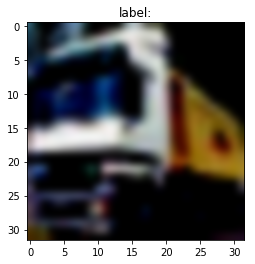

In [23]:
print "cifar_train 길이: ", len(cifar_train)
print "cifar_test 길이", len(cifar_test)

# 데이터 하나 형태
image, label = cifar_train.__getitem__(1) # 1번째 데이터
print "image data 형태: ", image.size()
print "label: ", label

# 그리기
img = image.numpy() # image 타입을 numpy 로 변환 (3, 32, 32)

# (3, 32, 32) -> (32, 32, 8)
r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
#img = img.reshape(img.shape[1], img.shape[2],  img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label:")
plt.imshow(img2, interpolation='bicubic')
plt.show() 

In [24]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs, volatile=True)
        label = Variable(labels)
        
        output = imodel.forward(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
        
    print("Accuraracy of Test Data: {}".format(100*correct/total))

In [25]:
# ==== 3. 데이터 로드함수 ====
train_loader = torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [29]:
# ==== 4. 모델 선언 ====
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Dropout2d(0.2),
            nn.Linear(100,10)
        )
        
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
        
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        
        return out
        
# model = CNN()

netname = './nets/my_net01.pkl'
model = torch.load(netname)

In [30]:
# ==== 5. loss, optimizer ====
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [31]:
# ==== 6. 학습 ====
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = Variable(image)
        y_ = Variable(label)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%100 == 0:
            ComputeAccr(test_loader, model)
            # 학습된 파라미터 저장
            netname = './nets/my_net01.pkl'
            torch.save(model, netname, )

/home/ec2-user/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuraracy of Test Data: 34.6699981689
Accuraracy of Test Data: 35.1100006104
Accuraracy of Test Data: 35.4199981689
Accuraracy of Test Data: 36.1199989319
Accuraracy of Test Data: 36.9000015259
Accuraracy of Test Data: 37.1199989319
Accuraracy of Test Data: 38.8100013733
Accuraracy of Test Data: 38.8800010681
Accuraracy of Test Data: 38.5
Accuraracy of Test Data: 39.2599983215
Accuraracy of Test Data: 39.9500007629
Accuraracy of Test Data: 39.7599983215


Exception KeyboardInterrupt: KeyboardInterrupt() in <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f360394b110>> ignored


KeyboardInterrupt: 

(1) drop out
(3) weight initialization
(4) Data Normalization
(5) Batch Normalization